In [1]:
from  src.dataloader import *
from src.tsne import *
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib
from torchvision import transforms, datasets
import torchvision.models as models
from sklearn.manifold import TSNE
import torch.nn as nn

c:\Users\yanis\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] La procédure spécifiée est introuvable
  warn(f"Failed to load image Python extension: {e}")


716


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224])
tensor(0)


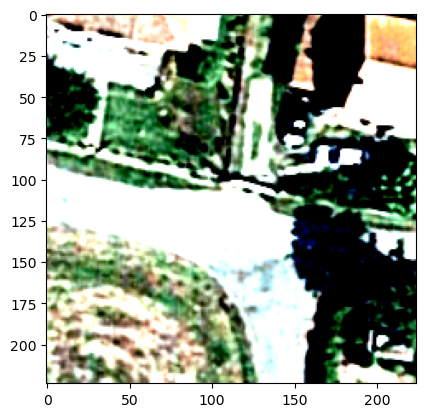

In [2]:
np.random.seed(123)
path_train="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/train_data.csv"
path_test="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/test_data.csv"

transformed_train_dataset  = CustomImageDataset_path(path_train,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google2/img/", transform=transforms.Compose([
                                               transforms.Resize(224),
                                               transforms.RandomCrop(190), #On garde environ 75% de l'image
                                               transforms.ColorJitter(brightness=(0.5,1.5),contrast=0,saturation=0,hue=0),                                               transforms.RandomCrop(160),
                                               transforms.Resize(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = [0.3492203652858734, 0.3565990626811981, 0.3071053624153137],
                                                                    std= [0.2003859430551529, 0.18338431417942047, 0.17826561629772186]),

                                           ]))

transformed_test_dataset = CustomImageDataset_path(path_test,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google2/img/",
                                            transform=transforms.Compose([
                                               transforms.Resize(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = [0.3498302698135376, 0.3575190603733063, 0.30798372626304626],
                                                                    std= [0.20142625272274017, 0.1843339055776596, 0.17957480251789093]),
                                           ]))

train_dataloader_augmente = DataLoader(transformed_train_dataset, batch_size=32, shuffle=True)
test_dataloader_augmente = DataLoader(transformed_test_dataset, batch_size=32, shuffle=True)

print(len(train_dataloader_augmente))
batch = next(iter(train_dataloader_augmente))
print(batch[0].shape)
plt.imshow(batch[0][0].permute(1, 2, 0))
print(batch[1][0])

In [3]:
resnet18 = models.resnet18(pretrained=True)
nr_filters = resnet18.fc.in_features  #number of input features of last layer
#On ne met pas de sigmoid dans la dernière couche. C'est composé par la loss BCEWithLogitsLoss qui applique une sigmoid afin de calculer la cross-enthropy
resnet18.fc = nn.Linear(nr_filters, 1)

resnet18.load_state_dict(torch.load("C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/trained_resnet18.pth"))

<All keys matched successfully>

In [4]:
def embedding(data):
    resnet18.eval()
    out = resnet18.conv1(data) #pass through CNN
    out= resnet18.bn1(out)
    out=resnet18.relu(out)
    out=resnet18.maxpool(out)
    out=resnet18.layer1(out)
    out=resnet18.layer2(out)
    out=resnet18.layer3(out)
    out=resnet18.layer4(out)
    out=torch.flatten(out, 1)
    return out

In [5]:
features = None
labels = None
image_paths = None

for data in test_dataloader_augmente:
    inputs=data[0]
    targets=data[1]
    paths=data[2]
    
    output = embedding(inputs)
    current_features = output.detach().numpy()
    if features is not None:
        features = np.concatenate((features, current_features))
    else:
        features = current_features

    if labels is not None:
        labels = np.concatenate((labels, targets))
    else:
        labels = targets
    
    if image_paths is not None:
        image_paths = np.concatenate((image_paths, paths))
    else:
        image_paths = paths

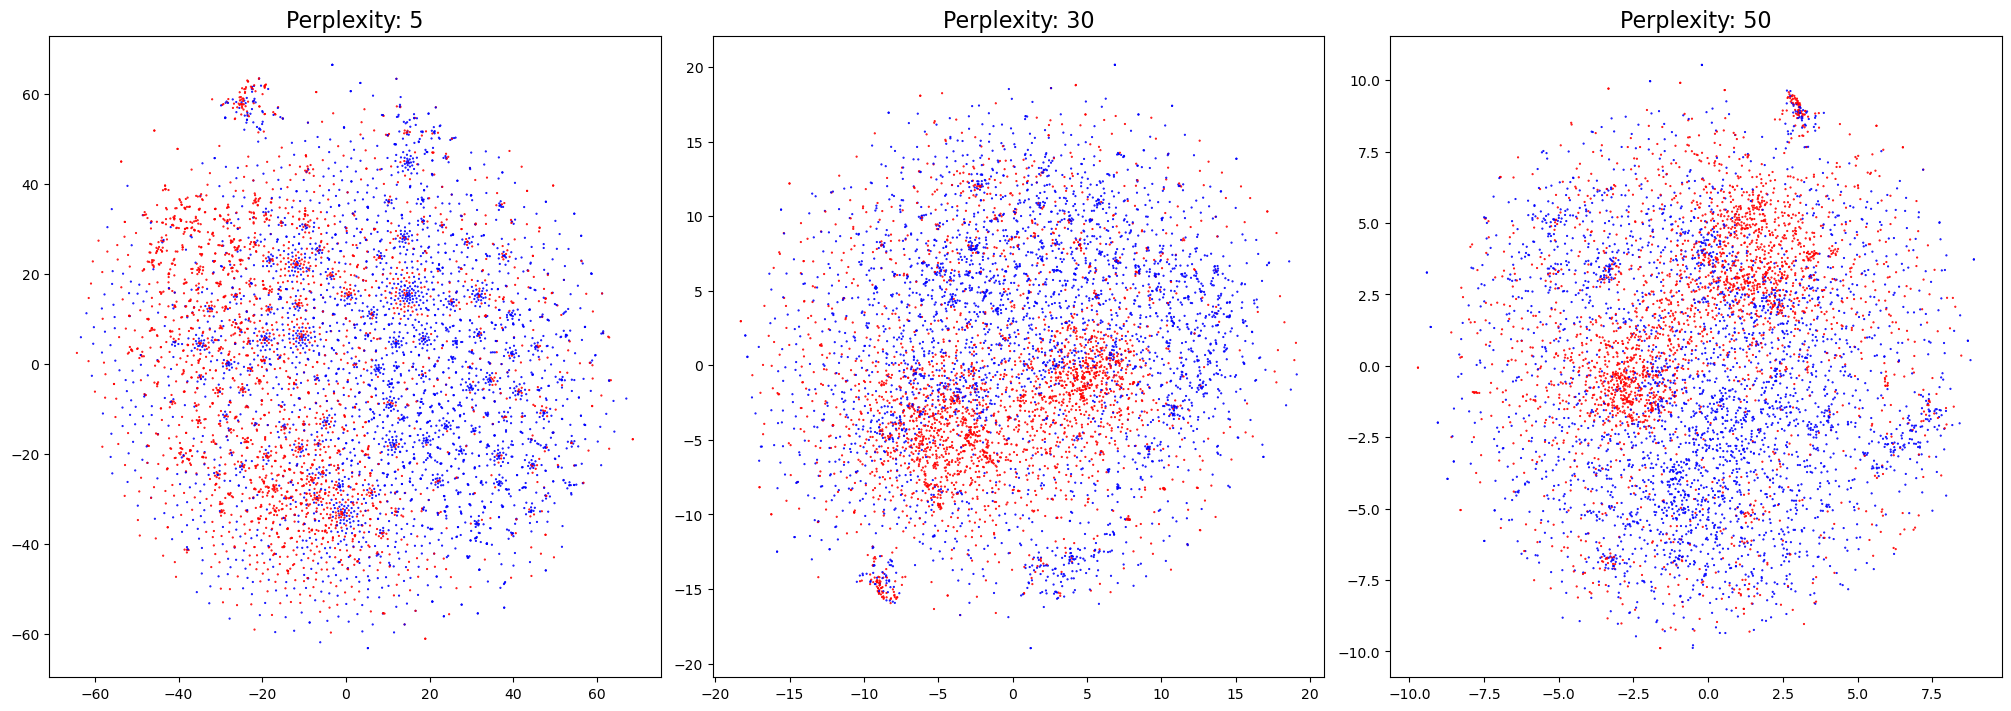

In [6]:
import itertools
fig, ax = plt.subplots(1, 3, figsize=(20,7), constrained_layout=True)

for c, per in zip(itertools.count(), [5, 30, 50]):
    tsne = TSNE(n_components=2,
                perplexity=per)
    tsne = tsne.fit_transform(features)
    scatter = ax[c].scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap=matplotlib.colors.ListedColormap(["red", "blue"]), s=0.3)
    ax[c].set_title(f'Perplexity: {per}', fontsize=16)  

In [7]:
tsne = TSNE(n_components=2, perplexity=30).fit_transform(features)

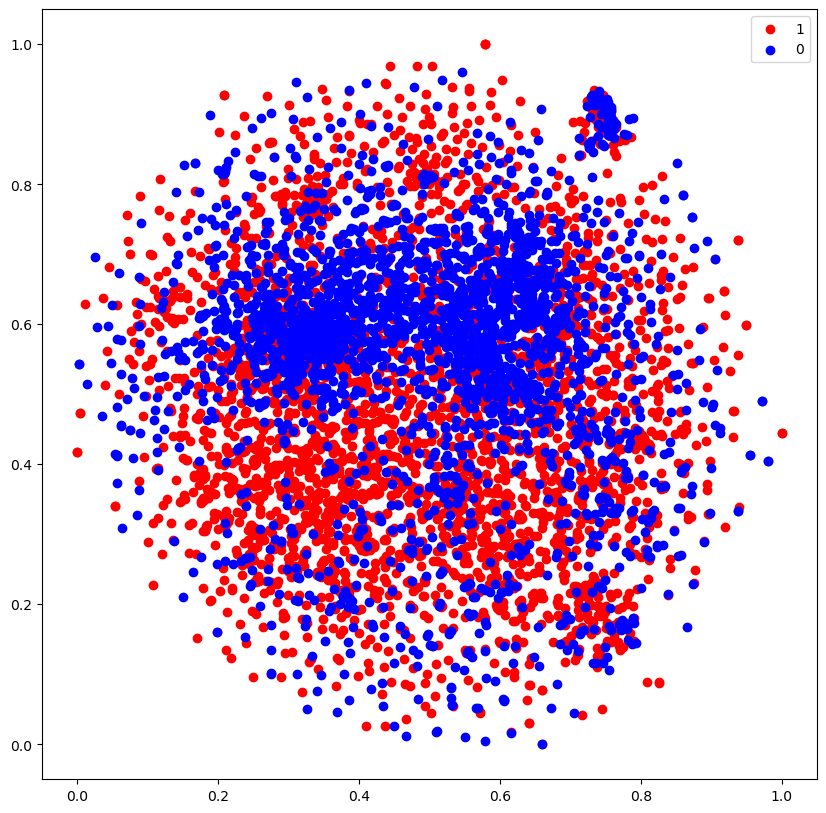

Building the T-SNE plot: 100%|██████████| 5727/5727 [00:16<00:00, 340.85it/s]


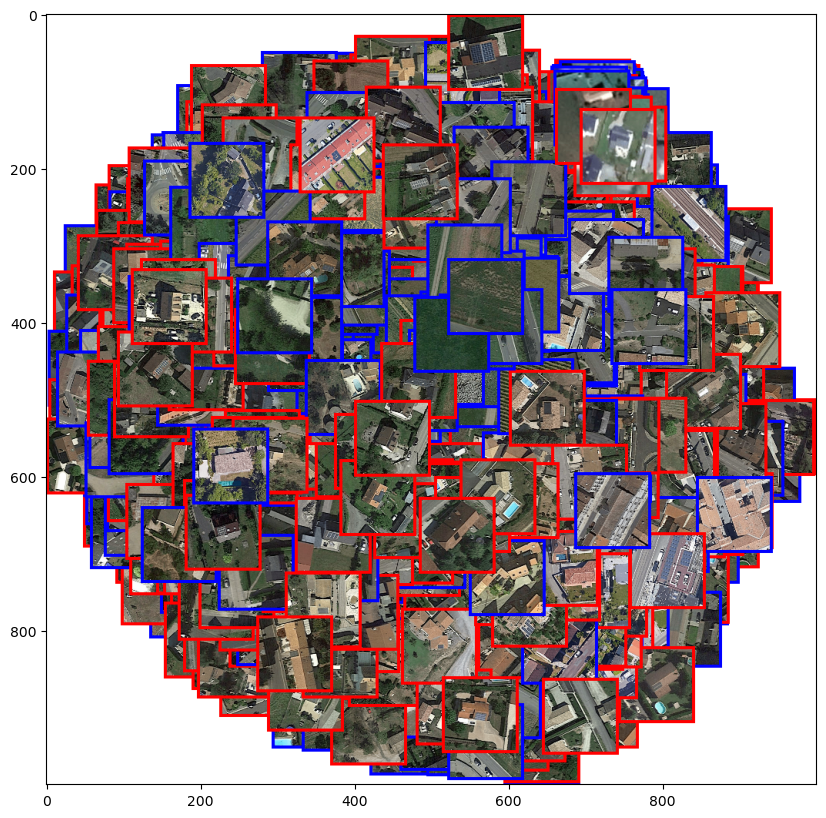

In [8]:
visualize_tsne(tsne, image_paths, labels)